In [1]:
import math
import time
import numpy as np
import pandas as pd
import torch
import gpytorch as gp
import botorch as bo
from botorch.models.gpytorch import GPyTorchModel
import matplotlib.pyplot as plt
from scipy.stats import norm, ttest_ind, ttest_rel

In [2]:
class prior(gp.models.ExactGP, GPyTorchModel):
    def __init__(self, train_inputs, train_targets, likelihood, kernel):
        super().__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gp.means.ConstantMean()
        self.covar_module = kernel
    
    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gp.distributions.MultivariateNormal(mean, covar)
        

def camel(x1, x2):
    ans = (4 - 2.1*x1**2 + x1**4/3)*x1**2
    ans += x1*x2
    ans += (-4 + 4*x2**2)*x2**2
    return ans

def a_ei(fmin, mean, std):
    ans = (fmin - mean) * norm.cdf((fmin - mean)/std)
    ans += std * norm.pdf((fmin - mean)/std)
    return ans

def gap(best_found, best_init, best):
    ans = (best_found - best_init)/(best - best_init)
    return ans

In [3]:
num = 1000
domain1 = torch.linspace(-3, 3, num)
domain2 = torch.linspace(-2, 2, num)
x1, x2 = torch.meshgrid(domain1, domain2, indexing="ij")
domain = torch.stack([x1.reshape(num*num, 1), x2.reshape(num*num, 1)], -1).squeeze(1)
f = torch.log(camel(domain[:, 0], domain[:, 1]) + 1.2)

num_runs = 20
times = torch.zeros((4, num_runs))
gaps_single = torch.zeros((num_runs, 32))
gaps_batch_2 = torch.zeros((num_runs, 32))
gaps_batch_4 = torch.zeros((num_runs, 32))
gaps_batch_8 = torch.zeros((num_runs, 32))

for run in range(num_runs):
    D_idx = np.random.choice(num*num, 5, False)
    D_X = domain[D_idx]
    D_y = f[D_idx]

    for idx in D_idx:
        domain = torch.cat((domain[:idx], domain[idx+1:]), dim=0)
        f = torch.cat((f[:idx], f[idx+1:]))

    D_fmin = torch.min(D_y)
    fmin_init = torch.min(D_y)
    best = math.log(-1.0316+1.2)

    for exp in range(4):
        start = time.time()
        # Setup
        D_X_cur = D_X.clone()
        D_y_cur = D_y.clone()
        D_fmin_cur = torch.min(D_y_cur)
        D_fmax_cur = torch.max(D_y_cur)
        domain_cur = domain.clone()
        f_cur = f.clone()

        budget = 2**(5-exp)
        for t in range(budget):
            # Setup Model
            likelihood = gp.likelihoods.FixedNoiseGaussianLikelihood(noise=torch.ones(D_X_cur.shape[0])*(0.01**2))
            k = gp.kernels.ScaleKernel(gp.kernels.RBFKernel())
            model = prior(D_X_cur, D_y_cur, likelihood, k)
            training_iter = (t+1)*(2**exp)*10
            model.train()
            optimizer = torch.optim.Adam(model.parameters(), lr=.1)
            mll = gp.mlls.ExactMarginalLogLikelihood(likelihood, model)
            for _ in range(training_iter):
                optimizer.zero_grad()
                output = model(D_X_cur)
                loss = -mll(output, D_y_cur)
                loss.backward()
                optimizer.step()
            outputscale = model.covar_module.outputscale.item()
            lengthscale = model.covar_module.base_kernel.lengthscale.item()
            meanconstant = model.mean_module.constant.detach()[0]
            
            # Build Batch
            next_Xs = torch.zeros((2**exp, 2))
            next_ys = torch.zeros((2**exp))
            D_X_sim = D_X_cur.clone()
            D_y_sim = D_y_cur.clone()
            for b in range(2**exp):
                likelihood_sim = gp.likelihoods.FixedNoiseGaussianLikelihood(noise=torch.ones(D_X_sim.shape[0])*(0.01**2))
                k_sim = gp.kernels.ScaleKernel(gp.kernels.RBFKernel())
                k_sim.outputscale = outputscale
                k_sim.base_kernel.lengthscale = lengthscale
                model_sim = prior(D_X_sim, D_y_sim, likelihood_sim, k_sim)
                model_sim.mean_module.constant = torch.nn.parameter.Parameter(meanconstant.clone())

                # Find next point to add
                model_sim.eval()
                likelihood_sim.eval()
                with torch.no_grad(), gp.settings.fast_pred_var():
                    f_preds = likelihood_sim(model_sim(domain_cur), noise=torch.ones(domain_cur.shape[0]) * (0.01**2))
                f_means = f_preds.mean.detach()
                f_stds = torch.sqrt(f_preds.variance).detach()
                aqs_cur = a_ei(D_fmin_cur, f_means, f_stds)
                max_idx = torch.argmax(aqs_cur)
                next_X = domain_cur[max_idx]
                next_y = f_cur[max_idx]
                next_Xs[b] = next_X
                next_ys[b] = next_y
                domain_cur = torch.cat((domain_cur[:max_idx], domain_cur[max_idx+1:]), dim=0)
                f_cur = torch.cat((f_cur[:max_idx], f_cur[max_idx+1:]))

                # Simulate Observation
                D_X_sim = torch.cat((D_X_sim, next_X.reshape(1, -1)), dim=0)
                D_y_sim = torch.cat((D_y_sim, f_means[max_idx].reshape(1)), dim=0)
            
            # Add Batch to D
            D_X_cur = torch.cat((D_X_cur, next_Xs), dim=0)
            D_y_cur = torch.cat((D_y_cur, next_ys))
            D_fmin_cur = torch.min(D_y_cur)
            
            # Store gap
            if exp == 0:
                gaps_single[run, t] = gap(D_fmin_cur, fmin_init, best)
            elif exp == 1:
                for r in range(2**exp):
                    gaps_batch_2[run, t*(2**exp)+r] = gap(D_fmin_cur, fmin_init, best)
            elif exp == 2:
                for r in range(2**exp):
                    gaps_batch_4[run, t*(2**exp)+r] = gap(D_fmin_cur, fmin_init, best)
            elif exp == 3:
                for r in range(2**exp):
                    gaps_batch_8[run, t*(2**exp)+r] = gap(D_fmin_cur, fmin_init, best)

        end = time.time()
        times[exp, run] = end - start

mean_gaps_single = torch.mean(gaps_single, dim=0)
mean_gaps_batch_2 = torch.mean(gaps_batch_2, dim=0)
mean_gaps_batch_4 = torch.mean(gaps_batch_4, dim=0)
mean_gaps_batch_8 = torch.mean(gaps_batch_8, dim=0)

times_single = torch.mean(times[0], dim=0)
times_batch_2 = torch.mean(times[1], dim=0)
times_batch_4 = torch.mean(times[2], dim=0)
times_batch_8 = torch.mean(times[3], dim=0)

[]

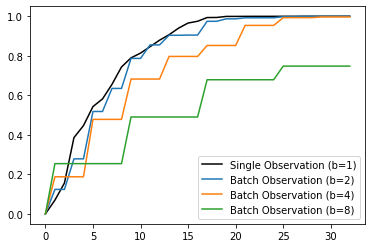

In [4]:
plt.plot(np.arange(0, 33), torch.cat((torch.zeros(1), mean_gaps_single)), label='Single Observation (b=1)', c="k")
plt.plot(np.arange(0, 33), torch.cat((torch.zeros(1), mean_gaps_batch_2)), label='Batch Observation (b=2)')
plt.plot(np.arange(0, 33), torch.cat((torch.zeros(1), mean_gaps_batch_4)), label='Batch Observation (b=4)')
plt.plot(np.arange(0, 33), torch.cat((torch.zeros(1), mean_gaps_batch_8)), label='Batch Observation (b=8)')
plt.legend()
plt.plot()

In [5]:
print(ttest_ind(mean_gaps_single, mean_gaps_batch_2))
print(ttest_ind(mean_gaps_batch_2, mean_gaps_batch_4))
print(ttest_ind(mean_gaps_batch_4, mean_gaps_batch_8))

Ttest_indResult(statistic=0.36839106038847474, pvalue=0.7138365439088001)
Ttest_indResult(statistic=0.9809065988144726, pvalue=0.33045107031610965)
Ttest_indResult(statistic=3.3904328179462695, pvalue=0.0012187616427190204)


In [6]:
print(times_single)
print(times_batch_2)
print(times_batch_4)
print(times_batch_8)

tensor(26.3962)
tensor(20.1476)
tensor(15.5050)
tensor(12.0856)
